In [1]:
import kagglehub
import shutil
import os

# Download latest version
path = kagglehub.dataset_download("noodulz/pokemon-dataset-1000")

# Create destination directory
os.makedirs('./dataset', exist_ok=True)

# Recursively copy all files from the dataset
def copy_files_recursively(src_path, dst_path):
    for item in os.listdir(src_path):
        src_item = os.path.join(src_path, item)
        dst_item = os.path.join(dst_path, item)

        if os.path.isdir(src_item):
            # If it's a directory, create it and copy contents
            os.makedirs(dst_item, exist_ok=True)
            copy_files_recursively(src_item, dst_item)
        else:
            # If it's a file, copy it
            shutil.copy2(src_item, dst_item)

# Copy all files from the dataset
copy_files_recursively(path, './dataset')

/opt/anaconda3/envs/ai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './dataset/pokemon-dataset-1000/train',
    image_size=(224, 224),
    batch_size=64,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './dataset/pokemon-dataset-1000/val',
    image_size=(224, 224),
    batch_size=64,
)

Found 25324 files belonging to 1000 classes.
Found 4536 files belonging to 1000 classes.


In [4]:
def preprocessing(data, target):
    data = tf.cast(data / 255.0, tf.float32)
    return data, target

In [5]:
train_ds = train_ds.map(preprocessing)
val_ds = val_ds.map(preprocessing)

In [6]:
print(train_ds)

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [9]:
input = tf.keras.layers.Input(shape=(224,224,3))

x = tf.keras.layers.Conv2D(64, kernel_size=(1,1), padding="same", activation="relu")(input)
x = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding="same", activation="relu")(x)

y = tf.keras.layers.Conv2D(64, kernel_size=(1,1), padding="same", activation="relu")(input)
y = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding="same", activation="relu")(y)

z = tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding="same")(input)
z = tf.keras.layers.Conv2D(64, kernel_size=(1,1), padding="same", activation="relu")(z)
z = tf.keras.layers.UpSampling2D((2,2))(z)

k = tf.keras.layers.Conv2D(64, kernel_size=(1,1), padding="same", activation="relu")(input)

concat1 = tf.keras.layers.Concatenate(axis=-1)([x,y,z,k])

output = tf.keras.layers.Conv2D(512, kernel_size=(1,1), padding="same", activation="relu")(concat1)
output = tf.keras.layers.GlobalAveragePooling2D()(output)
output = tf.keras.layers.Dense(1000, activation="softmax")(output)

# Create model
model = tf.keras.Model(inputs=input, outputs=output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 224, 224, 64  256         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 112, 112, 3)  0          ['input_2[0][0]']                
                                                                                            

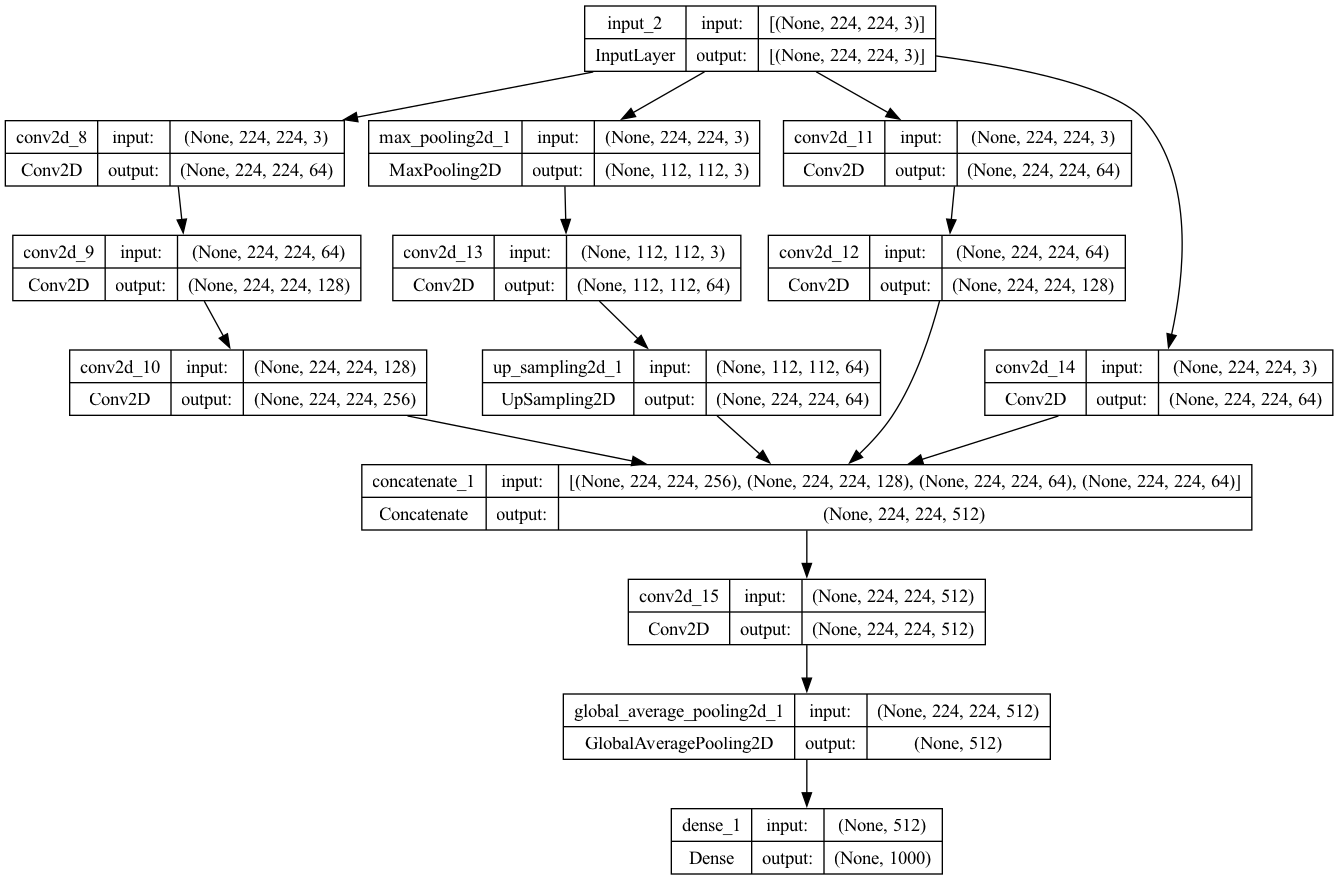

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [13]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,  # 여기에 실제 학습 데이터를 넣으세요
    validation_data=val_ds,  # 검증 데이터
    epochs=100,
    batch_size=32
)

Epoch 1/100


2025-01-08 22:31:17.895658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-01-08 22:31:17.945452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-01-08 22:31:18.068366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2025-01-08 22:31:18.609400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


In [ ]:
model.save('model.h5')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()